<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="360" height="160" /></center>

# <center>Seq2Seq Models with Attention Mechanism</center>

## Table of Contents

1. [Seq2Seq Models with Attention Mechanism](#section1)<br><br>
2. [Machine Translation Data](#section2)
  - 2.1 [Importing Libraries](#section201)<br><br>
  - 2.2 [Downloading the Dataset](#section202)<br><br>  
3. [Preprocessing the Data](#section3)
  - 3.1 [Limit the Size of the Dataset to Experiment Faster (Optional)](#section301)<br><br>
4. [Machine Translation Model with Attention Mechanism](#section4)
  - 4.1 [Create a tf.data Dataset](#section401)<br><br>
  - 4.2 [Write the Encoder and Decoder Model](#section402)<br><br>
    - 4.2.1 [Encoder Model](#section40201)<br><br>
    - 4.2.2 [Attention Layer](#section40202)<br><br>
    - 4.2.3 [Decoder Model](#section40203)<br><br>
  - 4.3 [Training the Model](#section403)<br><br>
    - 4.3.1 [Define the Optimizer and the Loss Function](#section40301)<br><br>
    - 4.3.2 [Checkpoints (Object-based Saving)](#section40302)<br><br>
    - 4.3.3 [Training](#section40303)<br><br>
5. [Translating](#section5)
  - 5.1 [Restore the Latest Checkpoint and Test](#section501)<br><br>
6. [Next Steps](#section6)

<a id=section1></a>
## 1. Seq2Seq Models with Attention Mechanism

The **encoder-decoder** model for recurrent neural networks is an architecture for **sequence-to-sequence** prediction problems.

It is comprised of **two sub-models**, as its name suggests:

  - **Encoder**: The *encoder* is responsible for *stepping through* the *input time steps* and *encoding* the *entire sequence into a fixed length vector* called a **context vector**.
<br><br>
  - **Decoder**: The *decoder* is responsible for *stepping through* the *output time steps while reading from* the **context vector**.

A **problem** with the *architecture* is that **performance** is **poor** on *long input or output sequences*. 

- The **reason** is believed to be because of the **fixed-sized internal representation** used by the *encoder*.

<br> 
**Attention** is an extension to the architecture that **addresses** this **limitation**. 

 - It **works** by first *providing* a *richer context from* the *encoder to* the *decoder*. 
 
 
 - And a **learning mechanism** where the *decoder can learn where to pay* **attention** in the *richer encoding when predicting each time step in* the *output sequence*.

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attention_mechanism.png"/></center>

We'll be using the following **process sequence** in this notebook:

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img0.png"/></center>

**Note:** The **code** used in this notebook is taken from the **official TensorFlow tutorials**.

<a id=section2></a>
## 2. Machine Translation Data

<a id=section201></a>
### 2.1 Importing Libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
# Import tensorflow 2.x
# This code block will only work in Google Colab.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
# If you have tensorflow 2.0 installed in your system, use this command directly to import tensorflow
# import tensorflow as tf

In [ ]:
# Checking whether GPU is available or not, to be used with tensorflow.
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0': raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import unicodedata
import re
import os
import io
import time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split

<a id=section202></a>
### 2.2 Downloading the Dataset

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img1.png"/></center>

We'll use a **language dataset** provided by [http://www.manythings.org/anki/](http://www.manythings.org/anki/). 

This **dataset contains language translation pairs** in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a *variety of languages available*, but we'll **use** the **English-Spanish dataset**. 

For convenience, **TensorFlow** has hosted a *copy of* this *dataset on Google Cloud*, but you can also download your own copy. 

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', 
                                      origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                      extract=True)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


<a id=section3></a>
## 3. Preprocessing the Data

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img2.png"/></center>

After **downloading** the **dataset**, here are the steps we'll take to prepare the data:

1. *Add* a ***start*** and ***end*** *token to each sentence*.


2. **Clean** the **sentences** by *removing special characters*.


3. **Create** a **word index** and **reverse word index** (*dictionaries mapping from word → id and id → word*).


4. **Pad each sentence** *to a maximum length*.

- This *function converts* the **unicode file to ascii**.

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

- This *function preprocesses* the **sentences**.

In [ ]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

- *Applying preprocess_sentence function on* a **custom input**.

In [ ]:
en_sentence = "May I borrow this book?"
sp_sentence = "¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


- This *function* will *create* a **clean dataset** by *applying* the *preprocess_sentence function* on our **dataset**.
  
  1. **Remove** the **accents**.
<br><br>  
  2. **Clean** the **sentences**.
<br><br>  
  3. **Return word pairs** in the format: **[ENGLISH, SPANISH]**

In [ ]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

- Showing an **example** of *create_dataset* function.

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


- *Function to calculate* the **max length** of the **dataset**.

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

- *Function to perform tokenization of* the **data** and *add padding* to the **tokenized output**.

In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

- This *function* will **load** the **dataset** and **preprocess** it using *create_dataset function*, and *then apply tokenize function* on it.

In [ ]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

<a id=section301></a>
### 3.1 Limit the Size of the Dataset to Experiment Faster (Optional)

*Training on* the *complete dataset of >100,000 sentences* will take a **long time**. 

*To train faster*, we can **limit** the **size** of the **dataset to 30,000 sentences** (of course, *translation quality degrades with less data*).

In [ ]:
# Try experimenting with the size of the dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_inp, max_length_targ = max_length(input_tensor), max_length(target_tensor)

- *Creating training* and *validation sets using* an **80-20 split**.

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, 
                                                                                                target_tensor, 
                                                                                                test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


- *Function to convert* the **word index** to the **word** in the **vocabulary**.

In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> i
77 ----> love
821 ----> spring
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
26 ----> yo
256 ----> amo
13 ----> la
919 ----> primavera
3 ----> .
2 ----> <end>


<a id=section4></a>
## 4. Machine Translation Model with Attention Mechanism

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img3.png"/></center>

<a id=section401></a>
### 4.1 Create a tf.data Dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 16]))

<a id=section402></a>
### 4.2 Write the Encoder and Decoder Model

**Implementing** an **encoder-decoder model with attention**:

*Each input word* is *assigned a weight by* the **attention mechanism** which is then used by the *decoder to predict* the *next word in the sentence*. 

The **input** is put through an *encoder* model which gives us the *encoder output* of shape *(batch_size, max_length, hidden_size)* and the *encoder hidden state* of shape *(batch_size, hidden_size)*.

<br> 

---

Here are the **equations** that are **implemented**:

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attention_equation1.jpg" alt="attention equation 1" width="800"></center>

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attention_equation2.jpg" alt="attention equation 2" width="800"></center>

<br> 

---

Here we **use** [**Bahdanau attention**](https://arxiv.org/pdf/1409.0473.pdf) for the *encoder*. 

Let's decide on **notation** before writing the simplified form:

- **FC** = Fully connected (dense) layer
- **EO** = Encoder output
- **H** = hidden state
- **X** = input to the decoder

<br> 

---

And the **pseudo-code**:

- `score = FC(tanh(FC(EO) + FC(H)))`


- `attention weights = softmax(score, axis = 1)`. **Softmax** by default is applied on the last axis but here we *want to apply it on* the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*.


- `Max_length` is the **length** of our **input**. Since we are trying to assign a weight to each input, *softmax should be applied on that axis*.


- `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as **1**.


- `embedding output` = The **input** to the *decoder X* is passed through an **embedding layer**.


- `merged vector = concat(embedding output, context vector)`


- This **merged vector** is then given to the **GRU**.

<br> 
The **shapes** of all the **vectors at each step** have been specified in the *comments in the code*.

<a id=section40201></a>
#### 4.2.1 Encoder Model

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img4.png"/></center>

- Creating a **class** for **Encoder** to easily access the *encoder model again and again*.

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, 
                                        return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

- Creating an object **encoder** of the *Encoder class*. 


- This will be our **encoder** model.

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


<a id=section40202></a>
#### 4.2.2 Attention Layer

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img5.png"/></center>

- Creating a **class** for **BahdanauAttention**.

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

- Creating an object **attention_layer** of *BahdanauAttention class*. 


- This will be our **attention mechanism**.

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


<a id=section40203></a>
#### 4.2.3 Decoder Model

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img6.png"/></center>

- Creating a **class** for **Decoder**.

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, 
                                        return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

- Creating an object **decoder** for *Decoder class*. 


- This will be our **decoder** model.

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 9414)


<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img7.png"/></center>

<a id=section403></a>
### 4.3 Training the Model

<a id=section40301></a>
#### 4.3.1 Define the Optimizer and the Loss Function

- **Adding** an **optimizer (Adam)** and a **loss function (SparseCategoricalCrossentropy)** to our model.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<a id=section40302></a>
#### 4.3.2 Checkpoints (Object-based Saving)

- Specifying a **directory to save** our **model weights**.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

<a id=section40303></a>
#### 4.3.3 Training

1. **Pass** the ***input*** through the *encoder* which return *encoder output* and the *encoder hidden state*.


2. The *encoder output*, *encoder hidden state* and the *decoder input* (which is the *start token*) is **passed to** the **decoder**.


3. The **decoder returns** the *predictions* and the *decoder hidden state*.


4. The *decoder hidden state* is then **passed** back into the **model** and the *predictions* are *used to calculate the loss*.


5. Use *teacher forcing* to decide the **next input** to the *decoder*.


6. **Teacher forcing** is the technique where the *target word* is passed as the *next input* to the *decoder*.


7. The final step is to **calculate** the **gradients** and *apply it to* the *optimizer* and **backpropagate**.

- Creating the **train** function.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

- *Training the model*: Experiment with 10, 15, 20, 25, 30 epochs. 


- Everytime you want *to retrain* the *model from beginning*, run the code from the *Encoder class* code.


- **Otherwise** the *training* will *continue from where it was left off*, in the same session.

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.2437
Epoch 1 Batch 100 Loss 1.6149
Epoch 1 Batch 200 Loss 1.3743
Epoch 1 Batch 300 Loss 1.2814
Epoch 1 Loss 1.5357
Time taken for 1 epoch 128.84981656074524 sec

Epoch 2 Batch 0 Loss 1.1361
Epoch 2 Batch 100 Loss 1.1230
Epoch 2 Batch 200 Loss 0.9613
Epoch 2 Batch 300 Loss 1.0787
Epoch 2 Loss 1.0571
Time taken for 1 epoch 103.65218019485474 sec

Epoch 3 Batch 0 Loss 0.7410
Epoch 3 Batch 100 Loss 0.8659
Epoch 3 Batch 200 Loss 0.8764
Epoch 3 Batch 300 Loss 0.6985
Epoch 3 Loss 0.7653
Time taken for 1 epoch 102.18879508972168 sec

Epoch 4 Batch 0 Loss 0.6146
Epoch 4 Batch 100 Loss 0.5174
Epoch 4 Batch 200 Loss 0.5324
Epoch 4 Batch 300 Loss 0.5138
Epoch 4 Loss 0.5385
Time taken for 1 epoch 103.68163061141968 sec

Epoch 5 Batch 0 Loss 0.3052
Epoch 5 Batch 100 Loss 0.4109
Epoch 5 Batch 200 Loss 0.3435
Epoch 5 Batch 300 Loss 0.4019
Epoch 5 Loss 0.3793
Time taken for 1 epoch 102.57004189491272 sec

Epoch 6 Batch 0 Loss 0.2100
Epoch 6 Batch 100 Loss 0.3083
Epoch 6 Batch 200

<a id=section5></a>
## 5. Translating

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img8.png"/></center>

- The **evaluate function** is similar to the *training loop*, except we don't use *teacher forcing* here. 


- The **input** to the *decoder at each time step is* its *previous predictions along with* the **hidden state** and the **encoder output**.


- **Stop predicting** when the **model predicts** the *end token*.


- And **store** the *attention weights for every time step*.

<br> 
Note: The **encoder output** is *calculated only once for one input*.

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

- *Function* for *plotting* the **attention weights**.

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention, cmap='viridis')
    fig.colorbar(cax)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

- *Function* to *translate English input to Spanish output* and *plot attention weights using* the **evaluate** and **plot_attention functions** defined above.

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<a id=section501></a>
### 5.1 Restore the Latest Checkpoint and Test

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/attn_img9.png"/></center>

- **Restoring** the **latest checkpoint** in `checkpoint_dir`.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hello <end>
Predicted translation: hola . <end> 


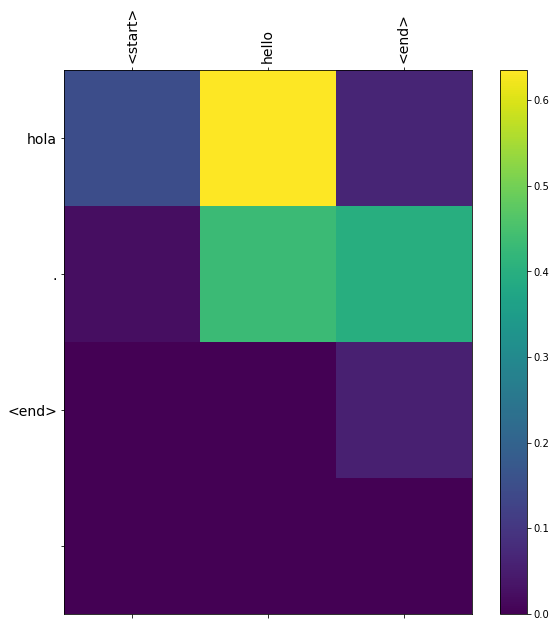

In [ ]:
translate('hello')

Input: <start> do they live here ? <end>
Predicted translation: ¿ ellos viven aqui ? <end> 


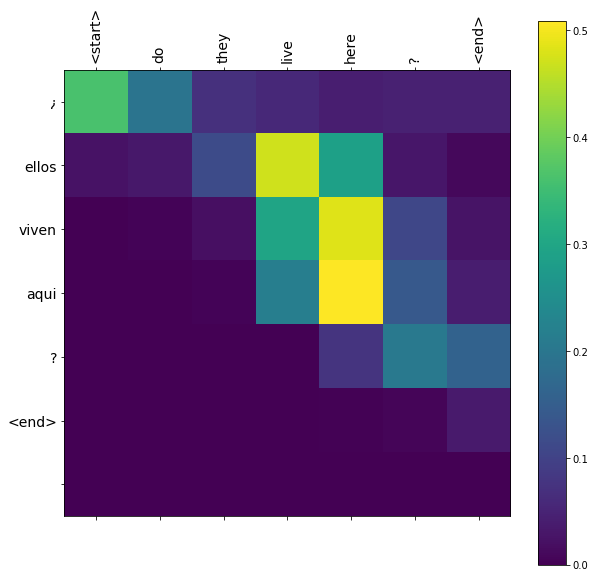

In [ ]:
translate('Do they live here?')

Input: <start> how are you ? <end>
Predicted translation: ¿ como estas ? <end> 


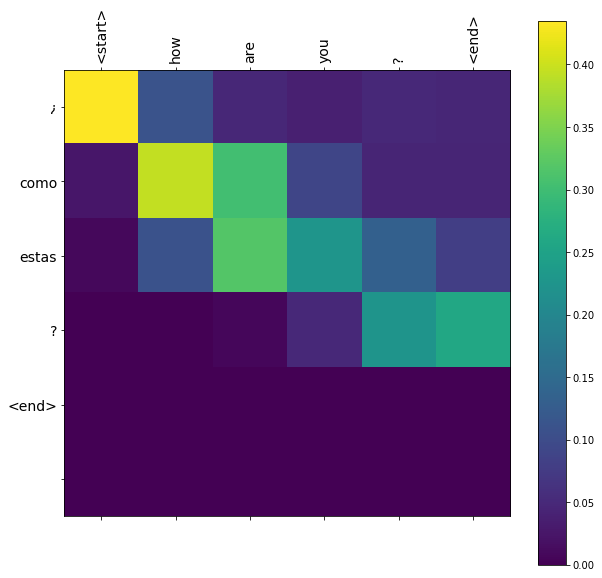

In [ ]:
translate('How are you?')

Input: <start> this is my life <end>
Predicted translation: esta es mi vida ? <end> 


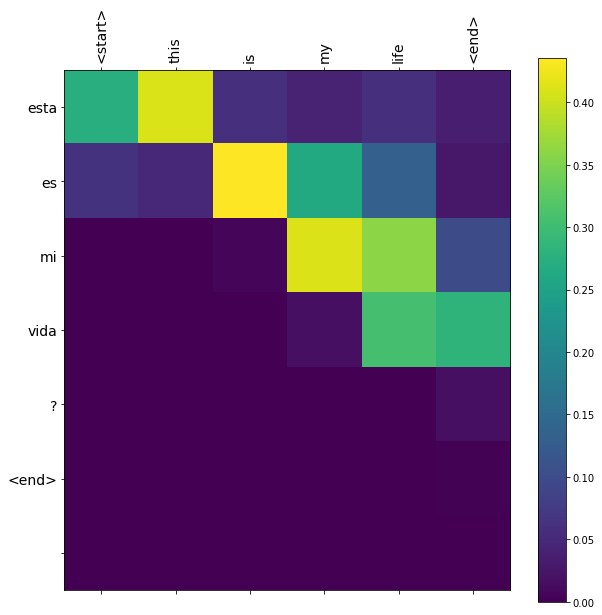

In [ ]:
translate('this is my life')

Input: <start> it s too cold here <end>
Predicted translation: hace demasiado frio aqui ? <end> 


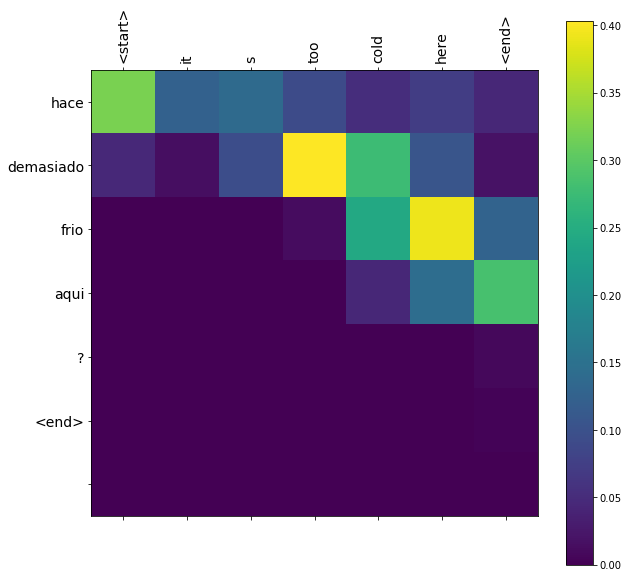

In [ ]:
translate("It's too cold here")

Input: <start> are you still at home ? <end>
Predicted translation: ¿ todavia estan en casa ? <end> 


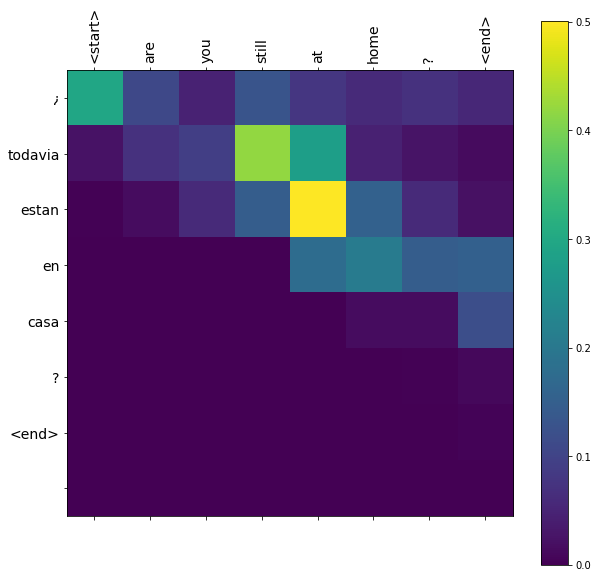

In [ ]:
translate('Are you still at home?')

<a id=section6></a>
### 6. Next Steps

- *Experiment with training on* a **larger dataset**, or using **more epochs**.


- *Experiment with* the **number of embedding dimensions**, **number of hidden units** used in the model.


- [**Download a different dataset**](http://www.manythings.org/anki/) *to experiment with translations*, for example, *English to German*, or *English to French*.